In [1]:
import torch
import math
import gpytorch
import numpy as np
from tqdm.notebook import tqdm
from torch import nn

import itertools
from functools import partial

import matplotlib.pyplot as plt
import copy
import os
import time
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from celluloid import Camera
from IPython.display import HTML


In [2]:

class MultitaskGPModel():
    def __init__(self, X, y, noise=.1, dt=1, ):
        self.dim = y.shape[1]
        self.gpr_list = []
        for i in range(y.shape[1]):
            #kernel = gp.kernels.RBF(input_dim=X.shape[1], variance=torch.tensor(1),
            #                        lengthscale=torch.tensor(1.))
            kernel = gp.kernels.Matern32(input_dim=X.shape[1])
            gpr = gp.models.GPRegression(X, y[:, i], kernel, noise=torch.tensor(noise / math.sqrt(dt)))
            self.gpr_list.append(gpr)

    def predict(self, X):
        mean_list = []
        for gpr in self.gpr_list:
            mean, _ = gpr(X, full_cov=True, noiseless=True)

            mean_list.append(mean.double().reshape((-1, 1)))
        return torch.cat(mean_list, dim=1)
    
    def fit_gp(self,gpr, num_steps=100):
        raise("To be implemented")
        #optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
        #loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
        #losses = []
        #for i in range(num_steps):
        #    optimizer.zero_grad()
        #    loss = loss_fn(gpr.model, gpr.guide)
        #    loss.backward()
        #    optimizer.step()
        #    losses.append(loss.item())


# %%

def solve_sde_RK(b_drift=None, sigma=None, X0=None, dt=1.0, N=100, t0=0.0,
                 theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(b_drift=None, sigma=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        b_drift  : Time dependan drift, the X state (with last dimension as time)
                defines the differential equation.
        sigma  : a  constant volatility
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)

    """
    N = int(N) + 1
    if b_drift is None or sigma is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape

    T = torch.tensor(dt * N)

    DWs = torch.empty((n, N - 1, d)).normal_(mean=0, std=1) * math.sqrt(dt)

    Y, ti = torch.zeros((n, N, d + 1)).double(), torch.arange(N).double() * dt + t0
    t0rep = (
        t0 * torch.ones((X0.shape[0], 1)).double() if forwards
        else (T - t0) * torch.ones((X0.shape[0], 1)).double()
    )
    Y = torch.cat((X0, t0rep), axis=1)[:, None, :]
    T = dt * N
    for n in range(N - 1):
        t = ti[n + 1]  # 1)
        b, DW_n = b_drift(Y[:, n, :]), DWs[:, n, :]
        newY = (
                Y[:, n, :-1] + b * dt + sigma * DW_n
        )

        trep = (
            t.repeat(newY.shape[0]).reshape(-1, 1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1, 1)
        )
        # print(trep)
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y, tocat), dim=1)
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()

    return ti, Y


# %%

def plot_trajectories_2(Xts, t, remove_time=True, fig_axs=None, color='b', show=True, direction="Forward"):
    """
    Helper function that plots multple trajctories
    """

    fn = 14
    if fig_axs is None:
        fig, axs = plt.subplots(1, 1, sharey=False, figsize=(15, 10))
        axs.set_ylabel("$x(t)$", fontsize=fn)
    else:
        fig, axs = fig_axs

    n, _, _, = Xts.shape

    if remove_time:
        Xts = Xts[..., :-1]

    for i in range(n):
        label = "$\mathbb{Q}$:" + f"{direction} process" if i == 0 else None
        axs.plot(t.cpu().flatten(), Xts[i, :, :].detach().cpu().numpy().flatten(), color, alpha=0.3, label=label)

    #     plt.show()
    return (fig, axs)


def MLEDrift(Xts,N,dt):
    X_0 = Xts[:, 0, 0].reshape(-1, 1)  # Extract starting point
    Ys = ((Xts[:, 1:, :-1] - Xts[:, :-1, :-1]) / dt).reshape((-1, Xts.shape[2] - 1)) # Autoregressive targets y = (X_{t+e} - X_t)/dt
    Xs = Xts[:, :-1, :].reshape((-1, Xts.shape[2])) #Drop the last timepoint in each timeseries 
    gp_drift_model = MultitaskGPModel(Xs, Ys)  # Setup the GP
    # fit_gp(gp_drift_model, num_steps=5) # Fit the drift
    gp_ou_drift = lambda x: gp_drift_model.predict(x)  # Extract mean drift
    return gp_ou_drift



def MLE_IPFP(X_0,X_1,N=10,sigma=1,iteration=10):
    drift_forward = lambda x: torch.tensor([0]*X_0.shape[1])
    dt = 1.0 / N


    # Estimating the backward drift of brownian motion
    # Start in X_0 and go forward. Then flip the series and learn a backward drift: drift_backward

    t, Xts = solve_sde_RK(b_drift=drift_forward, sigma=sigma, X0=X_0, dt=dt, N=N)
    #plot_trajectories_2(Xts, t)

    Xts[:,:,:-1] = Xts[:,:,:-1].flip(1) # Reverse the series
    drift_backward = MLEDrift(Xts,N=N,dt=dt)

    result = []
    for i in tqdm(range(iteration)):
        # Estimate the forward drift
        # Start from the end X_1 and then roll until t=0
        t, Xts = solve_sde_RK(b_drift=drift_backward, sigma=sigma, X0=X_1,dt=dt, N=N)
        #plot_trajectories_2(Xts, t)

        # Reverse the series
        Xts[:,:,:-1] = Xts[:,:,:-1].flip(1)
        drift_forward = MLEDrift(Xts,N=N,dt=dt)


        # Estimate backward drift
        # Start from X_0 and roll until t=1 using drift_forward
        t, Xts = solve_sde_RK(b_drift=drift_forward, sigma=sigma, X0=X_0,dt=dt, N=N)

        # Reverse the series
        Xts[:,:,:-1] = Xts[:,:,:-1].flip(1)

        drift_backward = MLEDrift(Xts,N=N,dt=dt)


        T, M = solve_sde_RK(b_drift=drift_forward, sigma=sigma, X0=X_0,dt=dt, N=N)
        T2, M2 = solve_sde_RK(b_drift=drift_backward, sigma=sigma, X0=X_1,dt=dt, N=N)
        result.append([T,M,T2,M2])
    return result



# Generating OU Based data

Here we simmulate some OU data using the EM SDE Solver . We will use this data to fit forwards and backwards drifts.

In [3]:
theta = 7.0
sigma = 1
dt = 0.01
N = int(math.ceil(1.0/dt))
b_drift = lambda x: -theta * x[...,:-1] 

In [4]:
num_samples = 15
dim = 1
mu, std = 5, 0.01
X_0 = torch.distributions.normal.Normal(loc=mu, scale=std).sample((num_samples, dim)) #.reshape(num_samples, dim,-1)

In [5]:
t, Xts = solve_sde_RK(b_drift=b_drift,sigma=sigma, X0=X_0, dt=dt, N=N)



(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:ylabel='$x(t)$'>)

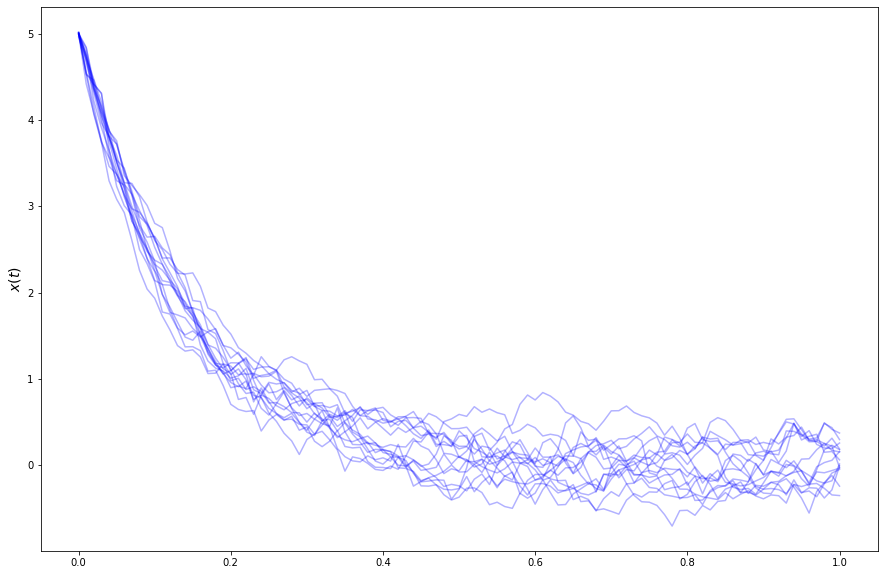

In [6]:
plot_trajectories_2(Xts, t, remove_time=True)

# Fitting Forward Drift with GP
In this section we demonstrate how to fit the forwards drift of an OU process using the GP drift fraemwork. Theres a small problem using Pyro I dont know why it doesnt let me flatten Ys , does it not support multioutput formats for GPs ?

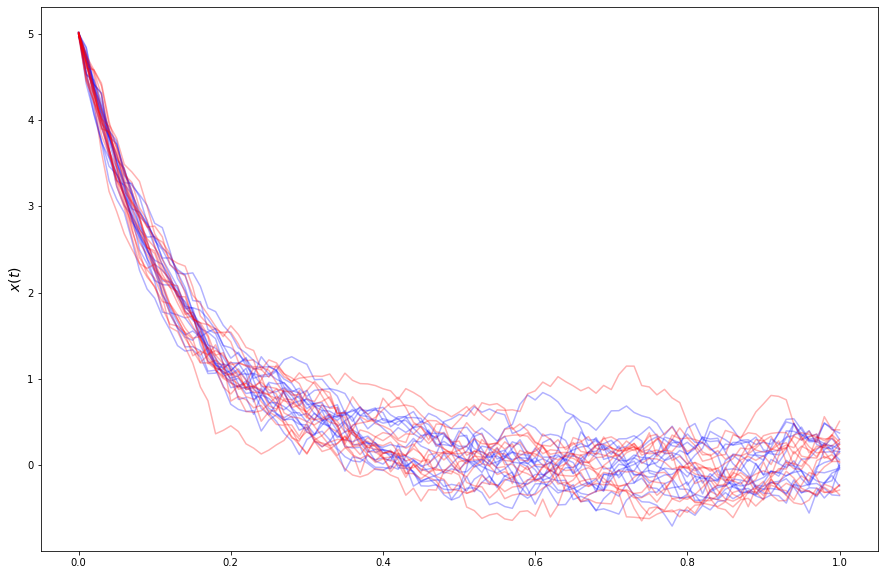

In [7]:
gp_ou_drift = MLEDrift(Xts,N,dt)

t_hat, Xts_hat = solve_sde_RK(b_drift=gp_ou_drift,sigma=sigma, X0=X_0, dt=dt, N=N) # Solver using GP predicted drift
fig_axs = plot_trajectories_2(Xts, t, remove_time=True, show=False)
plot_trajectories_2(Xts_hat, t_hat, remove_time=True, fig_axs=fig_axs, color='r');

# Fitting Backwards Drift with GP

In this section we reverse the time series before passing it to the GP. Then we inspect that if starting from the empirical hitting distribution of the OU process namely $X_1$ , where does our GP drift take us to, if correct it should take us back to $X_0$ .

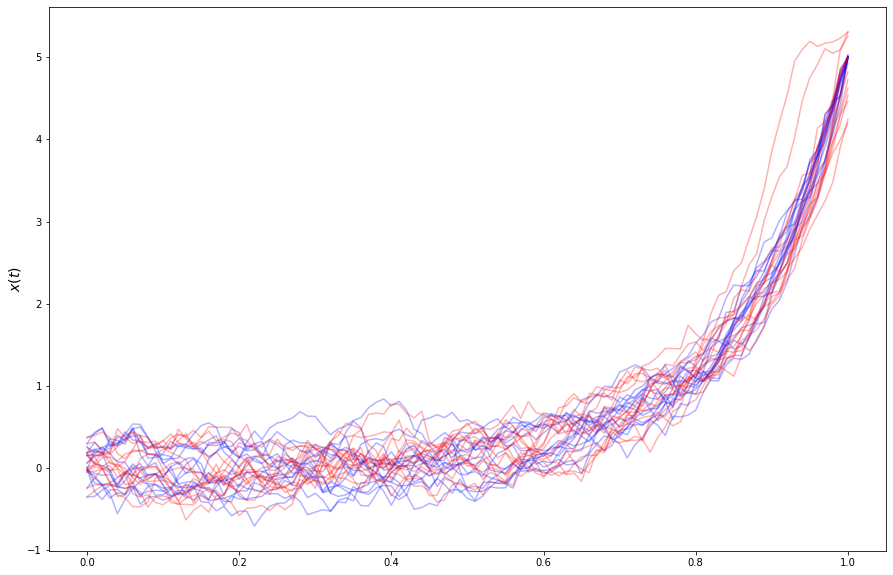

In [8]:
Xbts = copy.deepcopy(Xts)
Xbts[:,:,0] = Xbts[:,:,0].flip(1) # Reverse the series

gp_ou_drift = MLEDrift(Xbts,N,dt)
tb_hat, Xbts_hat = solve_sde_RK(b_drift=gp_ou_drift,sigma=sigma, X0=Xbts[:,0,0].reshape((-1,1)), dt=dt, N=N) # Solver using GP predicted drift

fig_axs = plot_trajectories_2(Xbts, t, remove_time=True, show=False)
plot_trajectories_2(Xbts_hat, tb_hat, remove_time=True, fig_axs=fig_axs, color='r');

#  IPFP

In [9]:
num_samples = 30
X_0 = torch.distributions.normal.Normal(loc=0, scale=0.5).sample((num_samples, 1)) #.reshape(num_samples, dim,-1)

X_1_a = torch.distributions.normal.Normal(loc=1.8, scale=0.6**2).sample((num_samples//2, 1)) 
X_1_b = torch.distributions.normal.Normal(loc=-1.9, scale=0.6**2).sample((num_samples//2, 1))
X_1 = torch.cat((X_1_a,X_1_b))

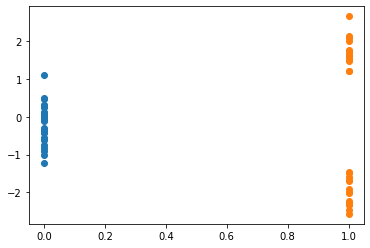

In [10]:
plt.scatter([0]*X_0.shape[0],X_0)
plt.scatter([1]*X_0.shape[0],X_1)

In [12]:
result = MLE_IPFP(X_0,X_1)

  0%|          | 0/10 [00:00<?, ?it/s]

(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:ylabel='$x(t)$'>)

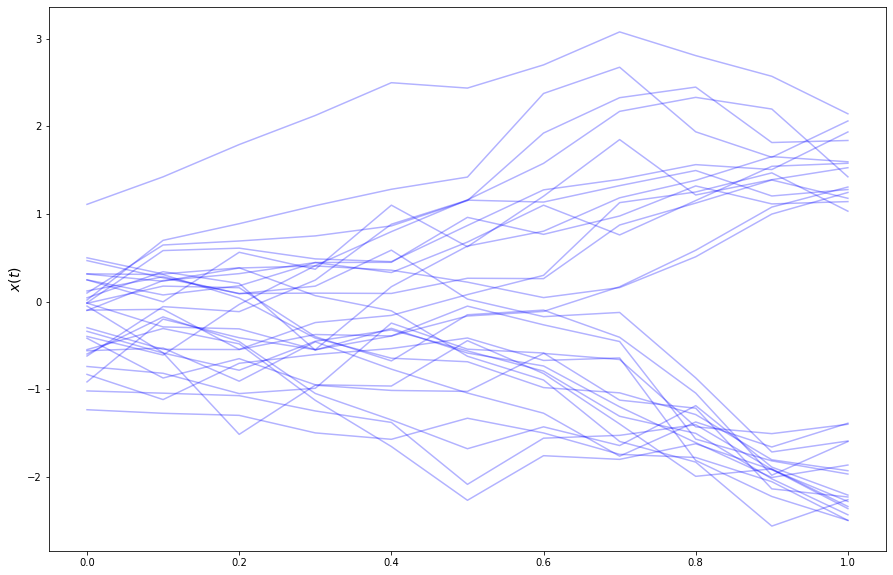

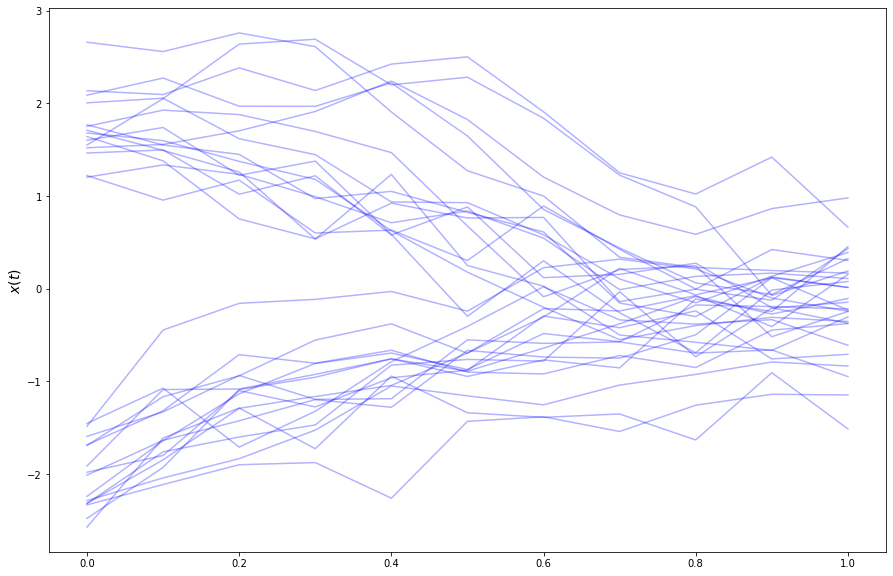

In [13]:
T,M,T2,M2 = result[-1]
plot_trajectories_2(M,T)
plot_trajectories_2(M2,  T2)

# 2D example

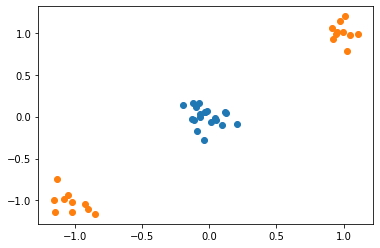

In [17]:
num_samples = 10
N = 20
X_0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2),torch.eye(2)*0.01).sample((num_samples*2,1)).reshape((-1,2))

X_1_a = torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(2),torch.eye(2)*0.01).sample((num_samples,1)).reshape((-1,2))
X_1_b = torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(2)*-1,torch.eye(2)*0.01).sample((num_samples,1)).reshape((-1,2))
X_1 = torch.cat((X_1_a,X_1_b))

# TO reshape
plt.scatter(X_0[:,0],X_0[:,1])
plt.scatter(X_1[:,0],X_1[:,1])


In [18]:

result = MLE_IPFP(X_0,X_1,N=N,sigma=0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

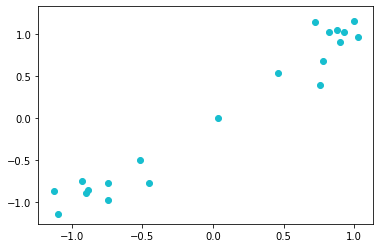

In [19]:
fig = plt.figure()
camera = Camera(fig)
M = result[-1][1]
for i in range(N):    
    plt.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')
